In [2]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU



In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import os
import tqdm
import torch

Defining url for datasets


In [4]:
train_ds_url = "Teeth DataSet/Teeth_Dataset/Training"
test_ds_url = "Teeth DataSet/Teeth_Dataset/Testing"
val_ds_url = "Teeth DataSet/Teeth_Dataset/Validation"

In [5]:
def load_images_from_folder(folder_path):
    dataset = keras.preprocessing.image_dataset_from_directory(
        folder_path,
        label_mode='categorical',
        image_size=(224, 224),
        batch_size=32,
        shuffle=True,
        seed=42
    
    )
    return dataset

In [6]:
train_ds = load_images_from_folder(train_ds_url)    
test_ds = load_images_from_folder(test_ds_url)
val_ds = load_images_from_folder(val_ds_url)

Found 3087 files belonging to 7 classes.
Found 1508 files belonging to 10 classes.
Found 1028 files belonging to 7 classes.


2025-07-05 19:33:04.144270: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-05 19:33:04.144299: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-07-05 19:33:04.144304: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-07-05 19:33:04.144307: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-05 19:33:04.144310: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: noureldeen
2025-07-05 19:33:04.144312: I external/local_xla/xla/stream_executor/cuda/cu

In [7]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


2025-07-05 19:33:06.281904: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


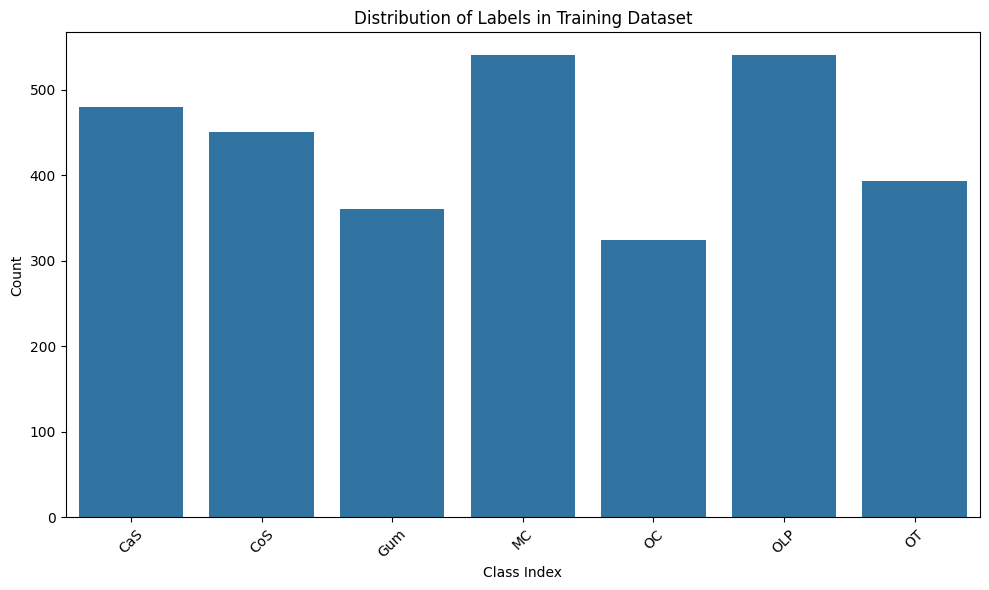

In [8]:
def get_all_labels(dataset):
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())
    return np.array(all_labels)

train_labels = get_all_labels(train_ds)

plt.figure(figsize=(10, 6))
sns.countplot(x=np.argmax(train_labels, axis=1))
plt.title('Distribution of Labels in Training Dataset')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()


Data is biased towards mc and olp and is minimum in oc and gum so we will add weights


In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.arange(len(class_names)),
                                        y=np.argmax(train_labels, axis=1))
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


2025-07-05 19:33:08.394452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


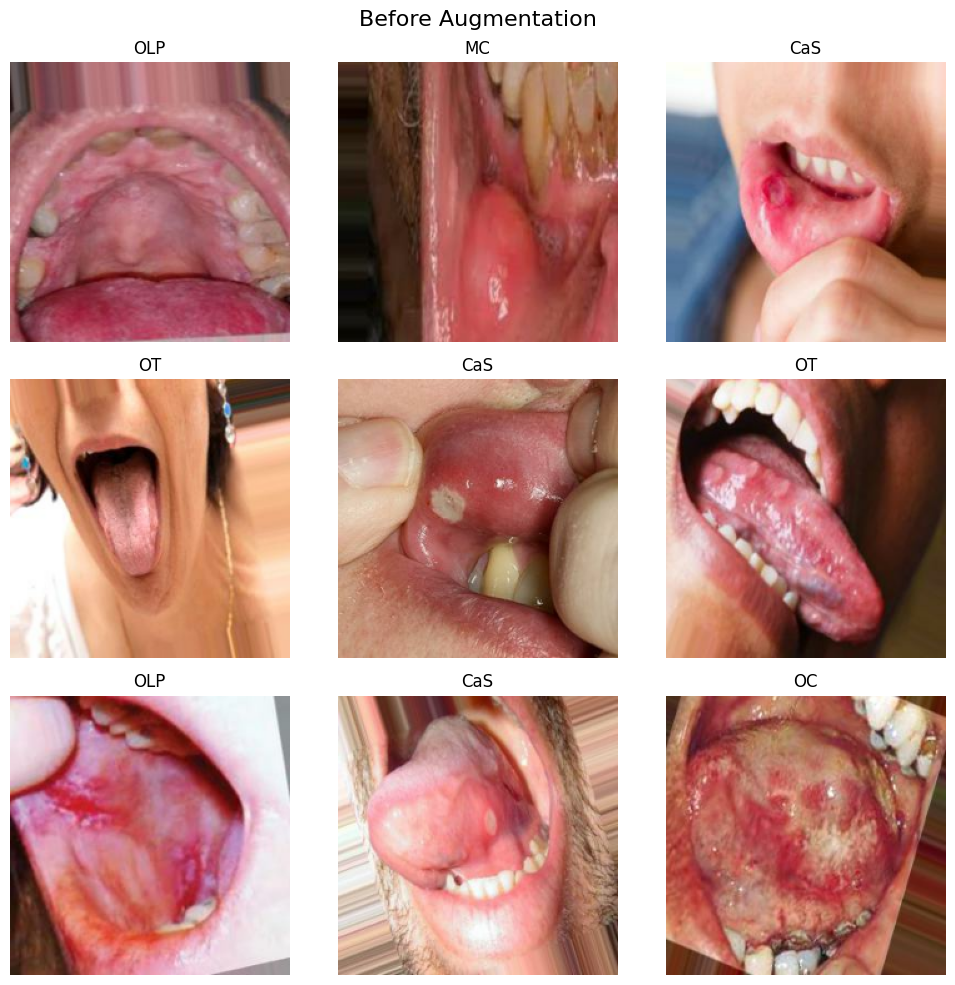

In [10]:
def show_batch(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = tf.argmax(labels[i]).numpy() if labels.shape[-1] > 1 else labels[i].numpy()
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle("Before Augmentation", fontsize=16)
    plt.tight_layout()
    plt.show()

show_batch(train_ds, class_names)


In [11]:
normalization_layer = keras.layers.Rescaling(1./255)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


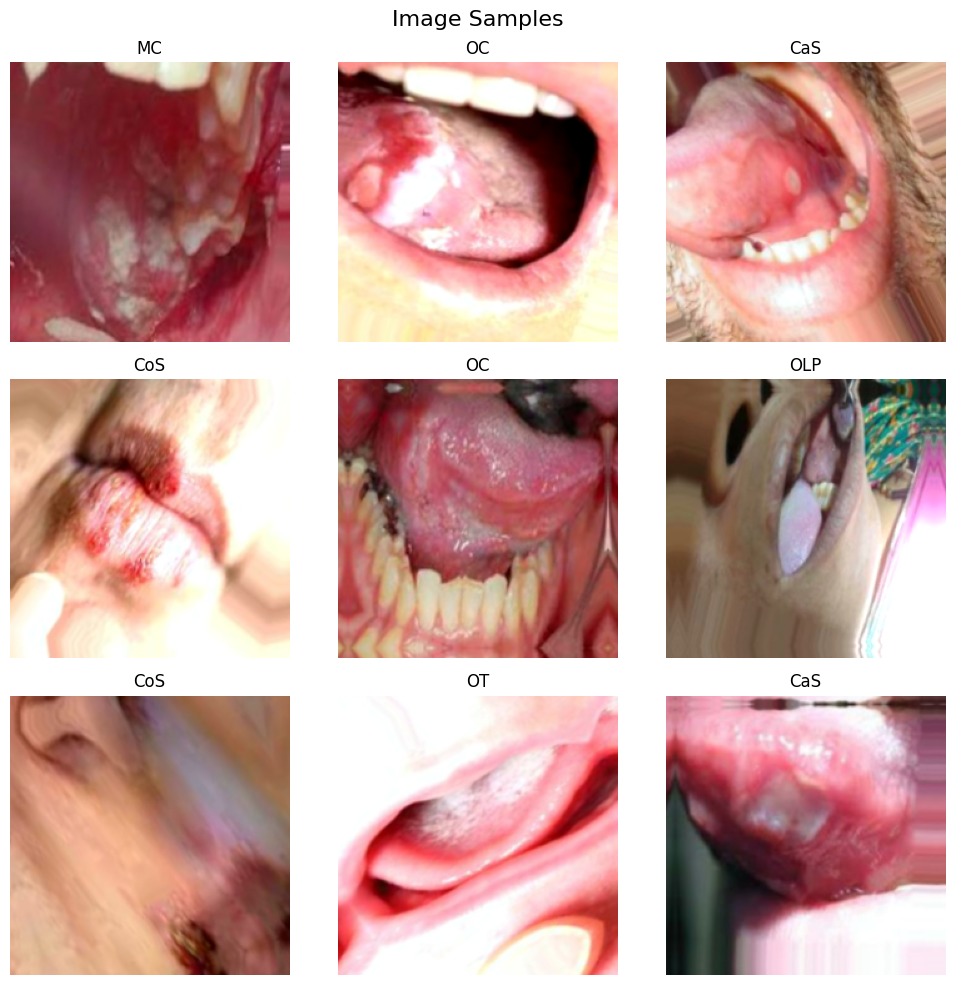

In [12]:
def show_batch(dataset, class_names, is_normalized=True):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            if is_normalized:
                img = np.clip(img * 255, 0, 255).astype("uint8")
            else:
                img = img.astype("uint8")
            plt.imshow(img)
            label = tf.argmax(labels[i]).numpy() if labels.shape[-1] > 1 else labels[i].numpy()
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle("Image Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_batch(train_ds, class_names, is_normalized=True)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3)),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'), 
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
model.summary()
    

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,759 (42.61 MB)

 Trainable params: 11,170,311 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,              
    patience=2,              
    min_lr=1e-7,             
    verbose=1                
)


history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30,
          class_weight=class_weights,
          callbacks=[
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
              reduce_lr
          ])

Epoch 1/20


 8/97 ━━━━━━━━━━━━━━━━━━━━ 1:00 679ms/step - Precision: 0.0894 - Recall: 0.0411 - accuracy: 0.1260 - loss: 3.9190

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

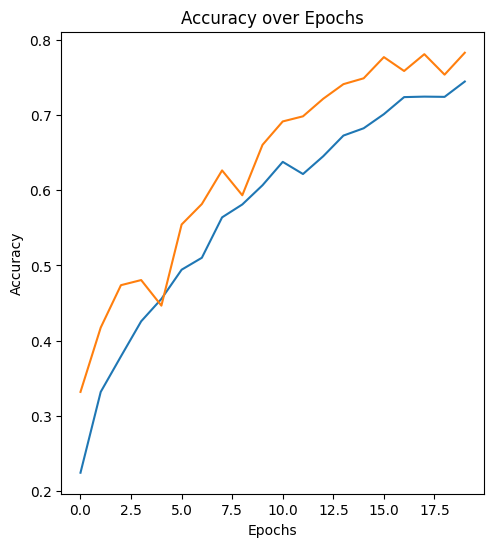

In [13]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


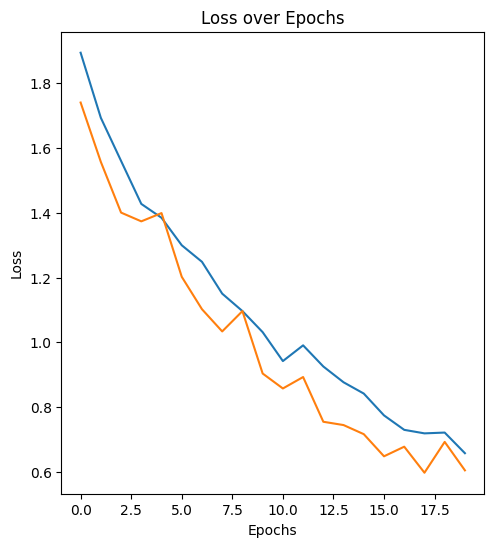

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()